In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import tempfile

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, \
                            precision_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow import keras

In [3]:
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
le = LabelEncoder()

customer_data['Churn'] = le.fit_transform(customer_data['Churn'])

In [6]:
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [7]:
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [8]:
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [9]:
print('Total: {}\n    Positive: {:.2f}\n    Negative: {:.2f}\n'.format(customer_data.shape[0],
                                                         customer_data['Churn'].value_counts(normalize=True)[1],
                                                         customer_data['Churn'].value_counts(normalize=True)[0]))

Total: 7032
    Positive: 0.27
    Negative: 0.73



In [10]:
target = customer_data.pop('Churn')

customer_data_dum = pd.get_dummies(customer_data, columns=customer_data.select_dtypes(include='object').columns,
                                                   drop_first=True)

customer_data_dum['Churn'] = target

In [11]:
train_data, test_data = train_test_split(customer_data_dum, test_size=0.2, stratify=customer_data_dum['Churn'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Churn'])

In [12]:
train_data.head()

,Tenure,MonthlyCharges,TotalCharges,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_CrCa-A,PaymentMethod_ElCh,PaymentMethod_MaCh,Churn
1842,45,75.95,3273.80,1,0,0,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0
2754,3,41.35,107.25,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4166,32,19.80,587.70,1,1,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
6239,72,99.40,7285.70,1,0,1,0,1,0,1,...,1,0,1,0,1,1,0,1,0,0
2529,45,62.70,2791.50,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,1


In [13]:
train_labels = np.array(train_data.pop('Churn'))
bool_train_labels = train_labels != 0
validation_labels = np.array(validation_data.pop('Churn'))
test_labels = np.array(test_data.pop('Churn'))

train_features = np.array(train_data)
validation_features = np.array(validation_data)
test_features = np.array(test_data)

In [14]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', validation_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', validation_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4500,)
Validation labels shape: (1125,)
Test labels shape: (1407,)
Training features shape: (4500, 30)
Validation features shape: (1125, 30)
Test features shape: (1407, 30)


/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Negative distribution')

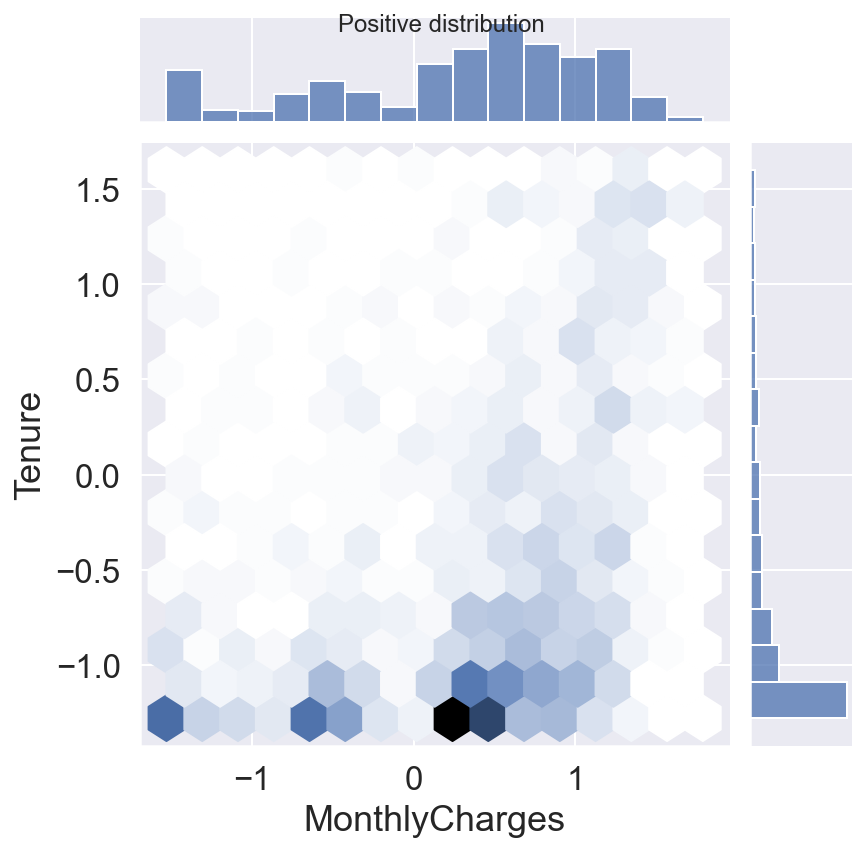

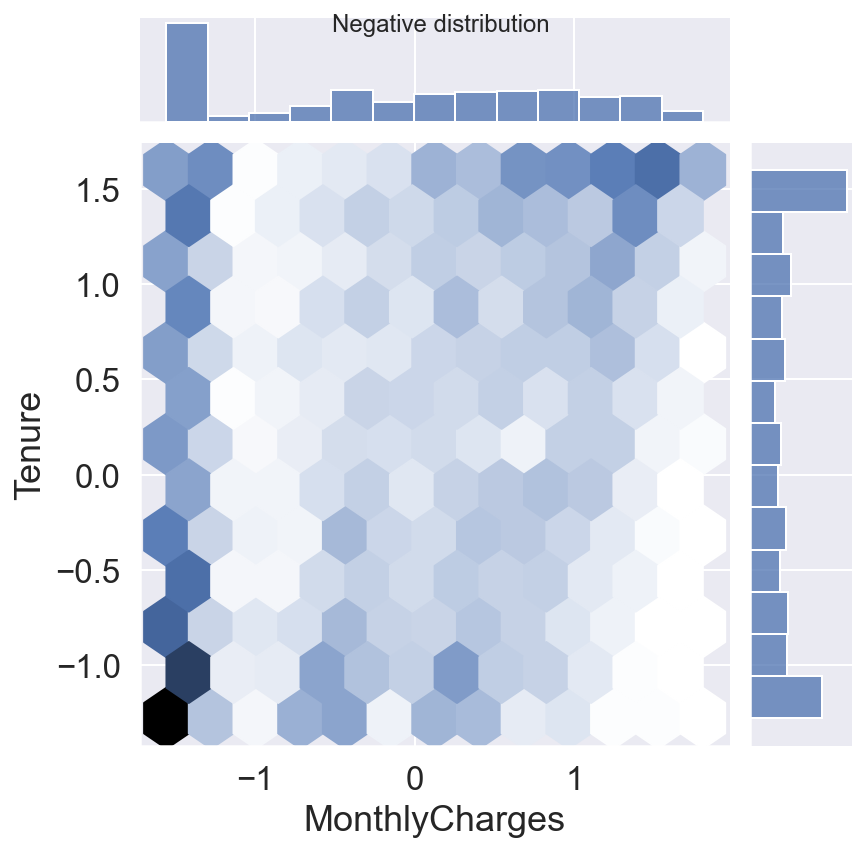

In [15]:
pos_data = pd.DataFrame(train_features[bool_train_labels], columns=train_data.columns)
neg_data = pd.DataFrame(train_features[~bool_train_labels], columns=train_data.columns)

sns.jointplot(pos_data['MonthlyCharges'], pos_data['Tenure'], kind='hex')
plt.suptitle('Positive distribution')

sns.jointplot(neg_data['MonthlyCharges'], neg_data['Tenure'], kind='hex')
plt.suptitle('Negative distribution')

In [16]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.AUC(name='prc', curve='PR'),]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(24, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.5),
                              keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
                              keras.layers.Dropout(0.4),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias),
                             ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [17]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                  verbose=1,
                                                  patience=15,
                                                  mode='max',
                                                  restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                744       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.predict(train_features[:10])

array([[0.6908666 ],
       [0.8044535 ],
       [0.7778875 ],
       [0.86875117],
       [0.8275794 ],
       [0.8414728 ],
       [0.5483539 ],
       [0.6369894 ],
       [0.68337333],
       [0.7642529 ]], dtype=float32)

In [19]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 1.0953


In [20]:
neg, pos = np.bincount(customer_data_dum['Churn'])

total = neg + pos

initial_bias = np.log([pos/neg])
initial_bias

array([-1.01611428])

In [21]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.317738  ],
       [0.22328365],
       [0.25345463],
       [0.3835752 ],
       [0.27376443],
       [0.33889276],
       [0.45798334],
       [0.28709602],
       [0.3125705 ],
       [0.2752686 ]], dtype=float32)

In [22]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.6261


In [23]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [24]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(validation_features, validation_labels),
                              verbose=0)

In [25]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features,
                                 train_labels,
                                 batch_size=BATCH_SIZE,
                                 epochs=20,
                                 validation_data=(validation_features, validation_labels),
                                 verbose=0)

In [26]:
def PlotLoss(history, label, color):
    plt.semilogy(history.epoch, history.history['loss'], color=color, label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=color, label='Validation ' + label, ls='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

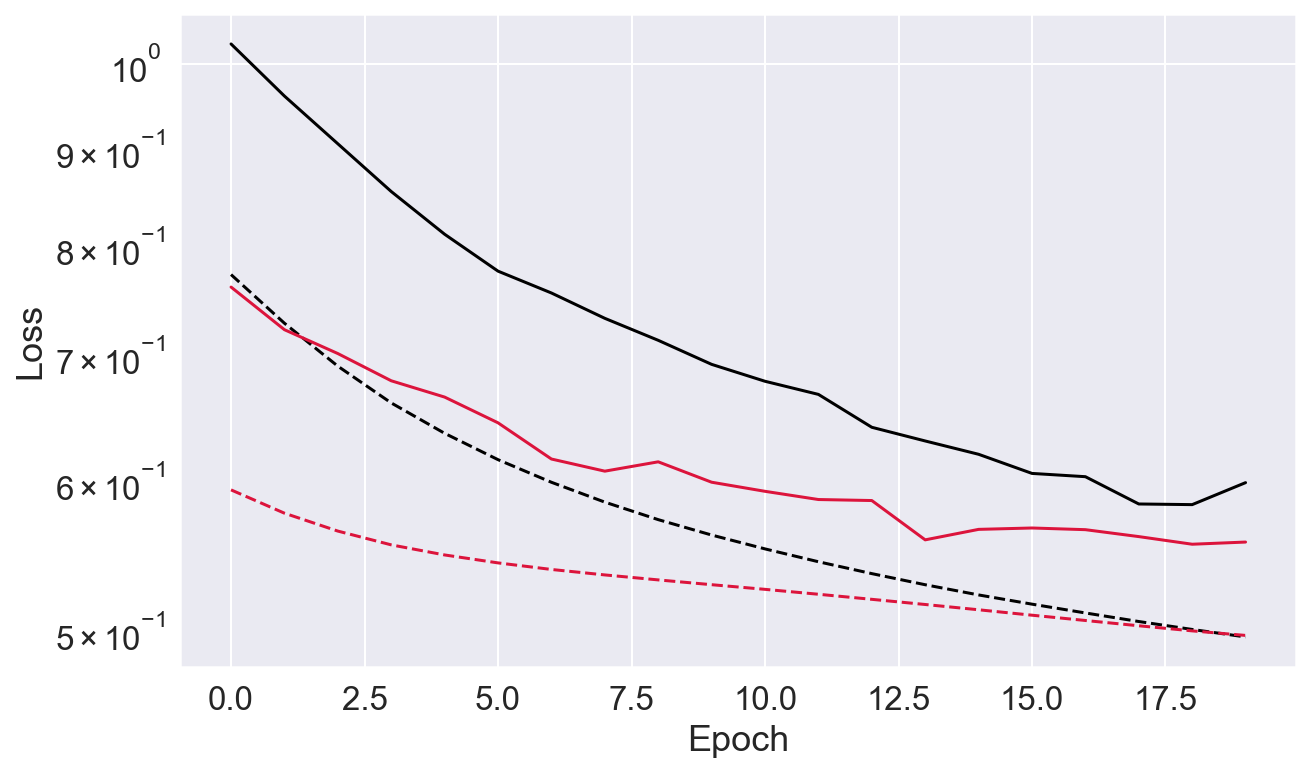

In [27]:
plt.figure(figsize=(10, 6))
PlotLoss(zero_bias_history, 'Zero Bias', 'black')
PlotLoss(careful_bias_history, 'Careful Bias', 'crimson')

In [28]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(validation_features, validation_labels))

Epoch 1/100
3/3 [==============================] - 2s 336ms/step - loss: 0.7986 - tp: 304.0000 - fp: 1089.0000 - tn: 3041.0000 - fn: 1191.0000 - accuracy: 0.5947 - precision: 0.2182 - recall: 0.2033 - auc: 0.5099 - prc: 0.2508 - val_loss: 0.5949 - val_tp: 4.0000 - val_fp: 21.0000 - val_tn: 805.0000 - val_fn: 295.0000 - val_accuracy: 0.7191 - val_precision: 0.1600 - val_recall: 0.0134 - val_auc: 0.5207 - val_prc: 0.2764
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.7277 - tp: 301.0000 - fp: 927.0000 - tn: 2377.0000 - fn: 895.0000 - accuracy: 0.5951 - precision: 0.2451 - recall: 0.2517 - auc: 0.5024 - prc: 0.2538 - val_loss: 0.5783 - val_tp: 1.0000 - val_fp: 8.0000 - val_tn: 818.0000 - val_fn: 298.0000 - val_accuracy: 0.7280 - val_precision: 0.1111 - val_recall: 0.0033 - val_auc: 0.5655 - val_prc: 0.3084
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.6975 - tp: 275.0000 - fp: 805.0000 - tn: 2499.0000 - fn: 921.0000 - accuracy: 0.6164

3/3 [==============================] - 0s 16ms/step - loss: 0.5434 - tp: 197.0000 - fp: 203.0000 - tn: 3101.0000 - fn: 999.0000 - accuracy: 0.7329 - precision: 0.4925 - recall: 0.1647 - auc: 0.6870 - prc: 0.4169 - val_loss: 0.4957 - val_tp: 6.0000 - val_fp: 0.0000e+00 - val_tn: 826.0000 - val_fn: 293.0000 - val_accuracy: 0.7396 - val_precision: 1.0000 - val_recall: 0.0201 - val_auc: 0.7960 - val_prc: 0.5727
Epoch 21/100
3/3 [==============================] - 0s 16ms/step - loss: 0.5418 - tp: 221.0000 - fp: 207.0000 - tn: 3097.0000 - fn: 975.0000 - accuracy: 0.7373 - precision: 0.5164 - recall: 0.1848 - auc: 0.6813 - prc: 0.4229 - val_loss: 0.4933 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 826.0000 - val_fn: 291.0000 - val_accuracy: 0.7413 - val_precision: 1.0000 - val_recall: 0.0268 - val_auc: 0.7983 - val_prc: 0.5747
Epoch 22/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5433 - tp: 195.0000 - fp: 244.0000 - tn: 3060.0000 - fn: 1001.0000 - accuracy: 0.7233 - pr

3/3 [==============================] - 0s 14ms/step - loss: 0.5150 - tp: 283.0000 - fp: 241.0000 - tn: 3063.0000 - fn: 913.0000 - accuracy: 0.7436 - precision: 0.5401 - recall: 0.2366 - auc: 0.7359 - prc: 0.4798 - val_loss: 0.4578 - val_tp: 54.0000 - val_fp: 26.0000 - val_tn: 800.0000 - val_fn: 245.0000 - val_accuracy: 0.7591 - val_precision: 0.6750 - val_recall: 0.1806 - val_auc: 0.8234 - val_prc: 0.5979
Epoch 40/100
3/3 [==============================] - 0s 15ms/step - loss: 0.5072 - tp: 309.0000 - fp: 231.0000 - tn: 3073.0000 - fn: 887.0000 - accuracy: 0.7516 - precision: 0.5722 - recall: 0.2584 - auc: 0.7448 - prc: 0.4986 - val_loss: 0.4572 - val_tp: 53.0000 - val_fp: 26.0000 - val_tn: 800.0000 - val_fn: 246.0000 - val_accuracy: 0.7582 - val_precision: 0.6709 - val_recall: 0.1773 - val_auc: 0.8236 - val_prc: 0.5996
Epoch 41/100
3/3 [==============================] - 0s 16ms/step - loss: 0.5083 - tp: 277.0000 - fp: 205.0000 - tn: 3099.0000 - fn: 919.0000 - accuracy: 0.7502 - precisi

3/3 [==============================] - 0s 14ms/step - loss: 0.4942 - tp: 350.0000 - fp: 208.0000 - tn: 3096.0000 - fn: 846.0000 - accuracy: 0.7658 - precision: 0.6272 - recall: 0.2926 - auc: 0.7695 - prc: 0.5192 - val_loss: 0.4447 - val_tp: 74.0000 - val_fp: 32.0000 - val_tn: 794.0000 - val_fn: 225.0000 - val_accuracy: 0.7716 - val_precision: 0.6981 - val_recall: 0.2475 - val_auc: 0.8324 - val_prc: 0.6120
Epoch 59/100
3/3 [==============================] - 0s 17ms/step - loss: 0.4840 - tp: 347.0000 - fp: 220.0000 - tn: 3084.0000 - fn: 849.0000 - accuracy: 0.7624 - precision: 0.6120 - recall: 0.2901 - auc: 0.7818 - prc: 0.5396 - val_loss: 0.4443 - val_tp: 74.0000 - val_fp: 32.0000 - val_tn: 794.0000 - val_fn: 225.0000 - val_accuracy: 0.7716 - val_precision: 0.6981 - val_recall: 0.2475 - val_auc: 0.8329 - val_prc: 0.6122
Epoch 60/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4846 - tp: 334.0000 - fp: 223.0000 - tn: 3081.0000 - fn: 862.0000 - accuracy: 0.7589 - precisi

3/3 [==============================] - 0s 13ms/step - loss: 0.4727 - tp: 358.0000 - fp: 215.0000 - tn: 3089.0000 - fn: 838.0000 - accuracy: 0.7660 - precision: 0.6248 - recall: 0.2993 - auc: 0.7945 - prc: 0.5513 - val_loss: 0.4379 - val_tp: 81.0000 - val_fp: 35.0000 - val_tn: 791.0000 - val_fn: 218.0000 - val_accuracy: 0.7751 - val_precision: 0.6983 - val_recall: 0.2709 - val_auc: 0.8365 - val_prc: 0.6166
Epoch 78/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4754 - tp: 384.0000 - fp: 231.0000 - tn: 3073.0000 - fn: 812.0000 - accuracy: 0.7682 - precision: 0.6244 - recall: 0.3211 - auc: 0.7925 - prc: 0.5540 - val_loss: 0.4378 - val_tp: 80.0000 - val_fp: 34.0000 - val_tn: 792.0000 - val_fn: 219.0000 - val_accuracy: 0.7751 - val_precision: 0.7018 - val_recall: 0.2676 - val_auc: 0.8365 - val_prc: 0.6166
Epoch 79/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4723 - tp: 368.0000 - fp: 196.0000 - tn: 3108.0000 - fn: 828.0000 - accuracy: 0.7724 - precisi

3/3 [==============================] - 0s 14ms/step - loss: 0.4671 - tp: 404.0000 - fp: 237.0000 - tn: 3067.0000 - fn: 792.0000 - accuracy: 0.7713 - precision: 0.6303 - recall: 0.3378 - auc: 0.7994 - prc: 0.5723 - val_loss: 0.4320 - val_tp: 89.0000 - val_fp: 43.0000 - val_tn: 783.0000 - val_fn: 210.0000 - val_accuracy: 0.7751 - val_precision: 0.6742 - val_recall: 0.2977 - val_auc: 0.8389 - val_prc: 0.6180
Epoch 97/100
3/3 [==============================] - 0s 15ms/step - loss: 0.4642 - tp: 415.0000 - fp: 246.0000 - tn: 3058.0000 - fn: 781.0000 - accuracy: 0.7718 - precision: 0.6278 - recall: 0.3470 - auc: 0.8001 - prc: 0.5729 - val_loss: 0.4317 - val_tp: 89.0000 - val_fp: 43.0000 - val_tn: 783.0000 - val_fn: 210.0000 - val_accuracy: 0.7751 - val_precision: 0.6742 - val_recall: 0.2977 - val_auc: 0.8391 - val_prc: 0.6178
Epoch 98/100
3/3 [==============================] - 0s 14ms/step - loss: 0.4730 - tp: 391.0000 - fp: 242.0000 - tn: 3062.0000 - fn: 805.0000 - accuracy: 0.7673 - precisi

In [29]:
def PlotMetrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace('_', ' ').capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color='black', label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], color='black', ls='--', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

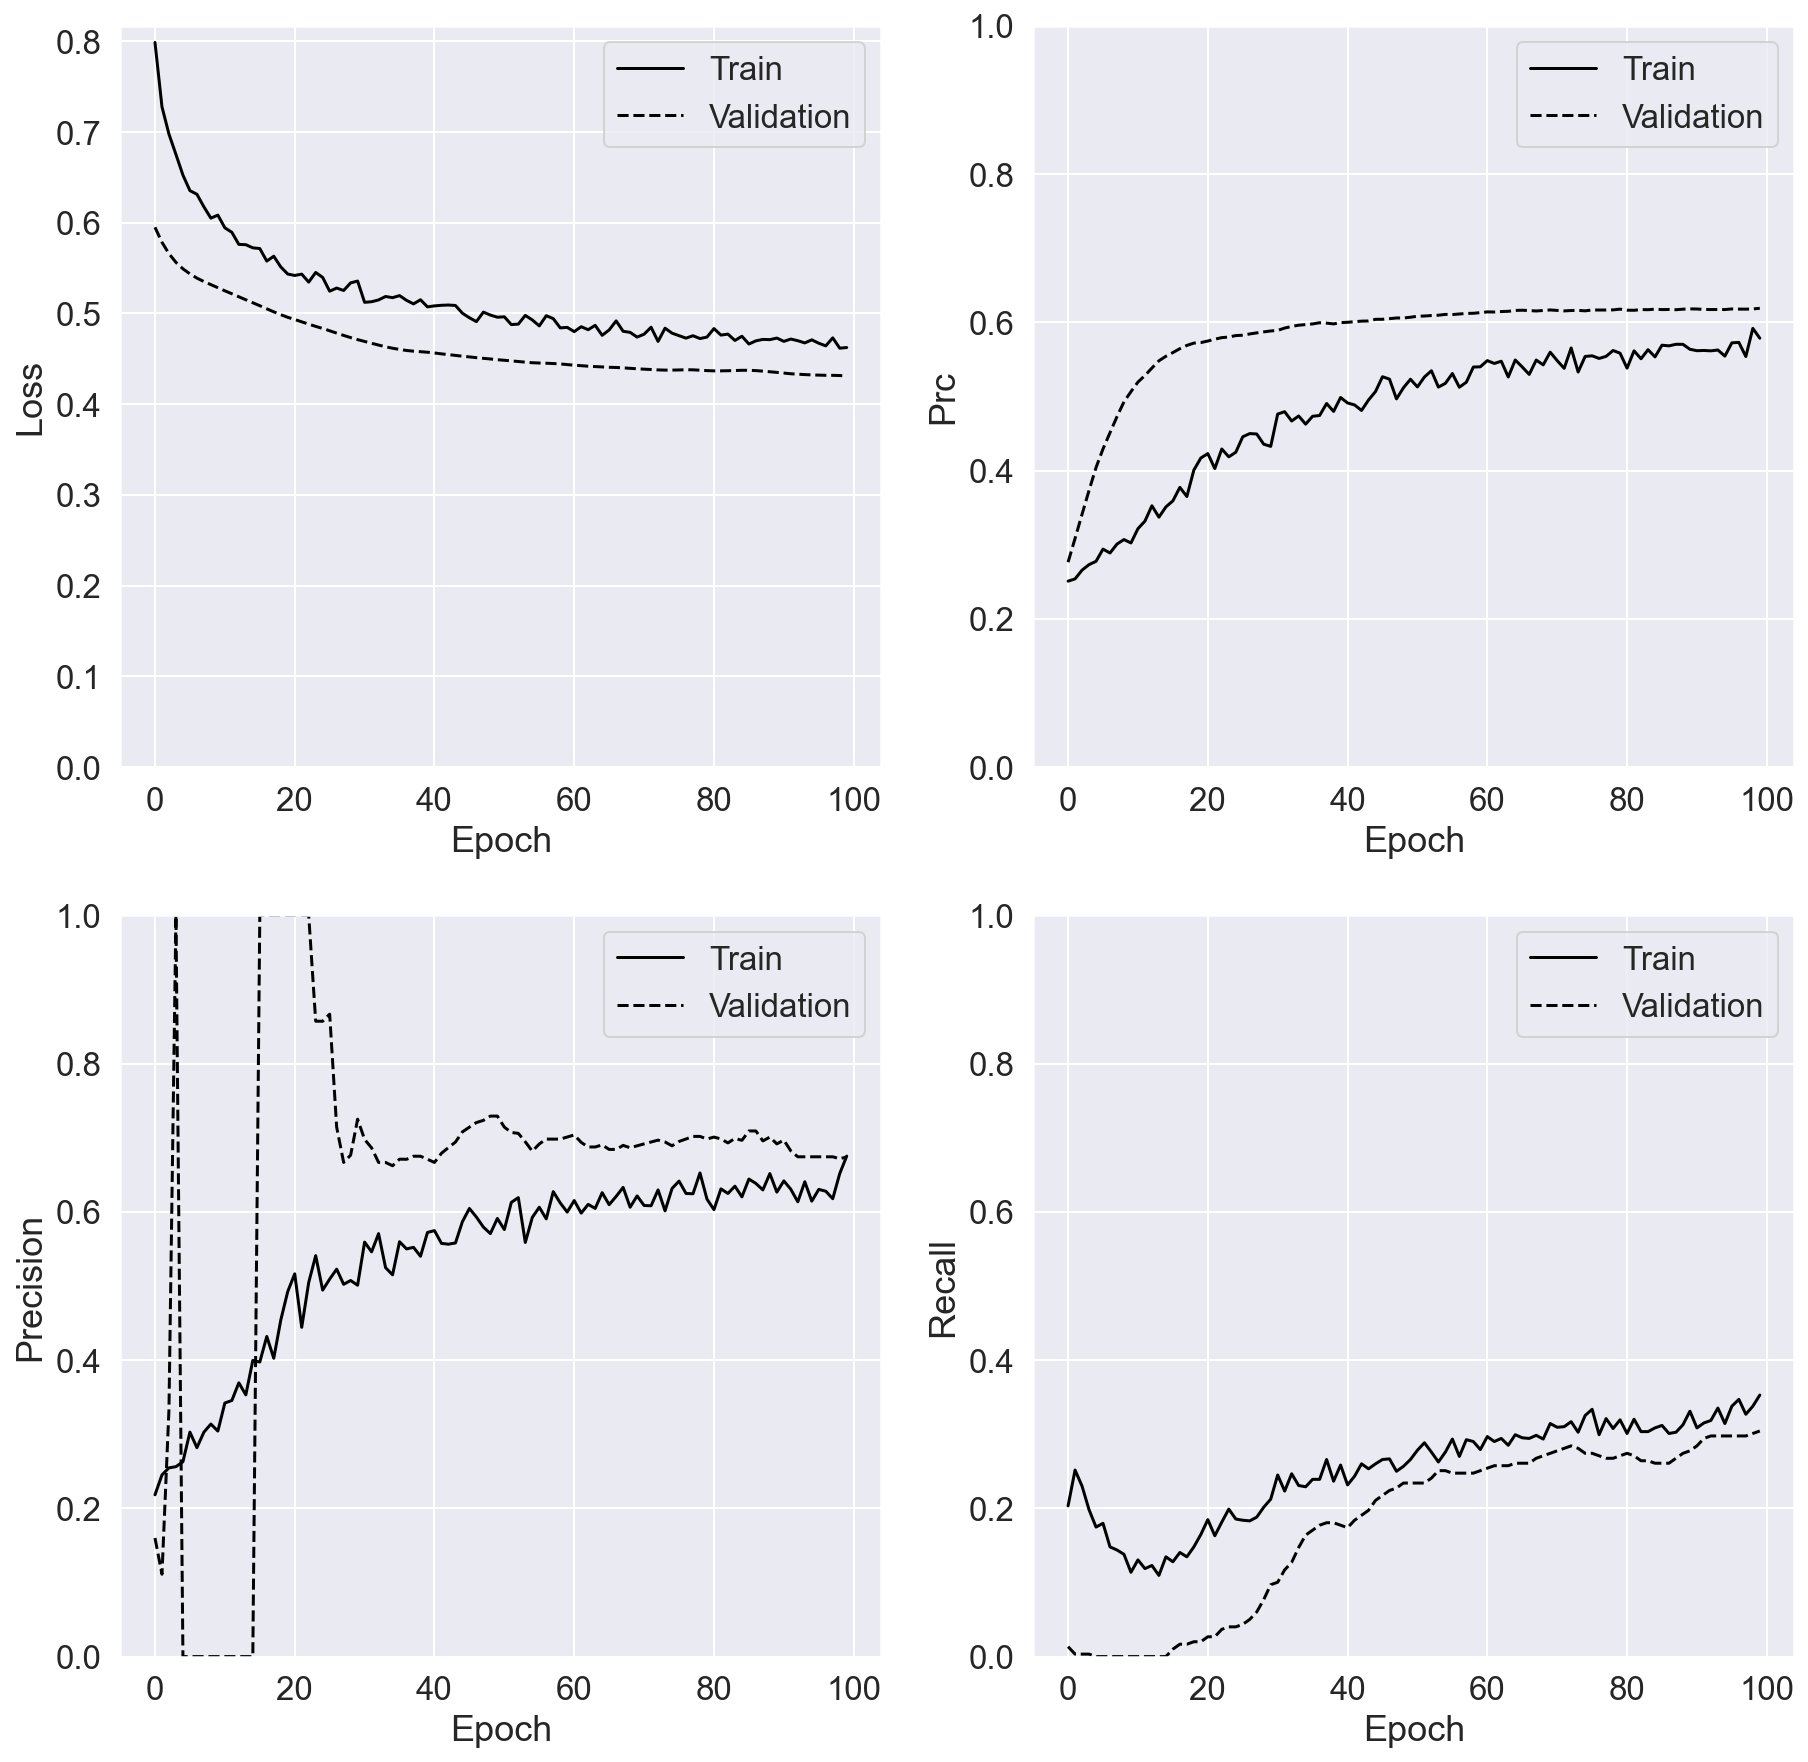

In [30]:
PlotMetrics(baseline_history)

In [31]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [32]:
def ConfMatrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.4339752793312073
tp :  119.0
fp :  39.0
tn :  994.0
fn :  255.0
accuracy :  0.7910447716712952
precision :  0.753164529800415
recall :  0.3181818127632141
auc :  0.8376011252403259
prc :  0.6484205722808838


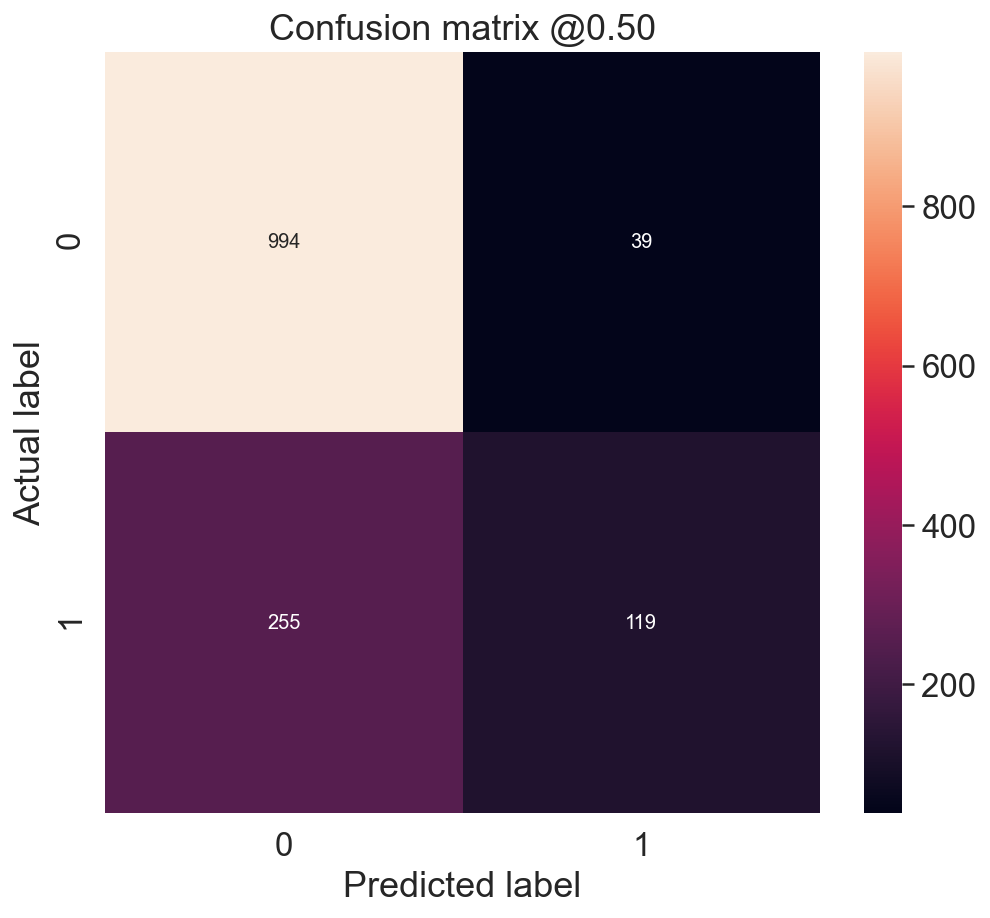

In [33]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_baseline)

In [34]:
def PlotROC(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, lw=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 100.5])
    plt.ylim([-0.5, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

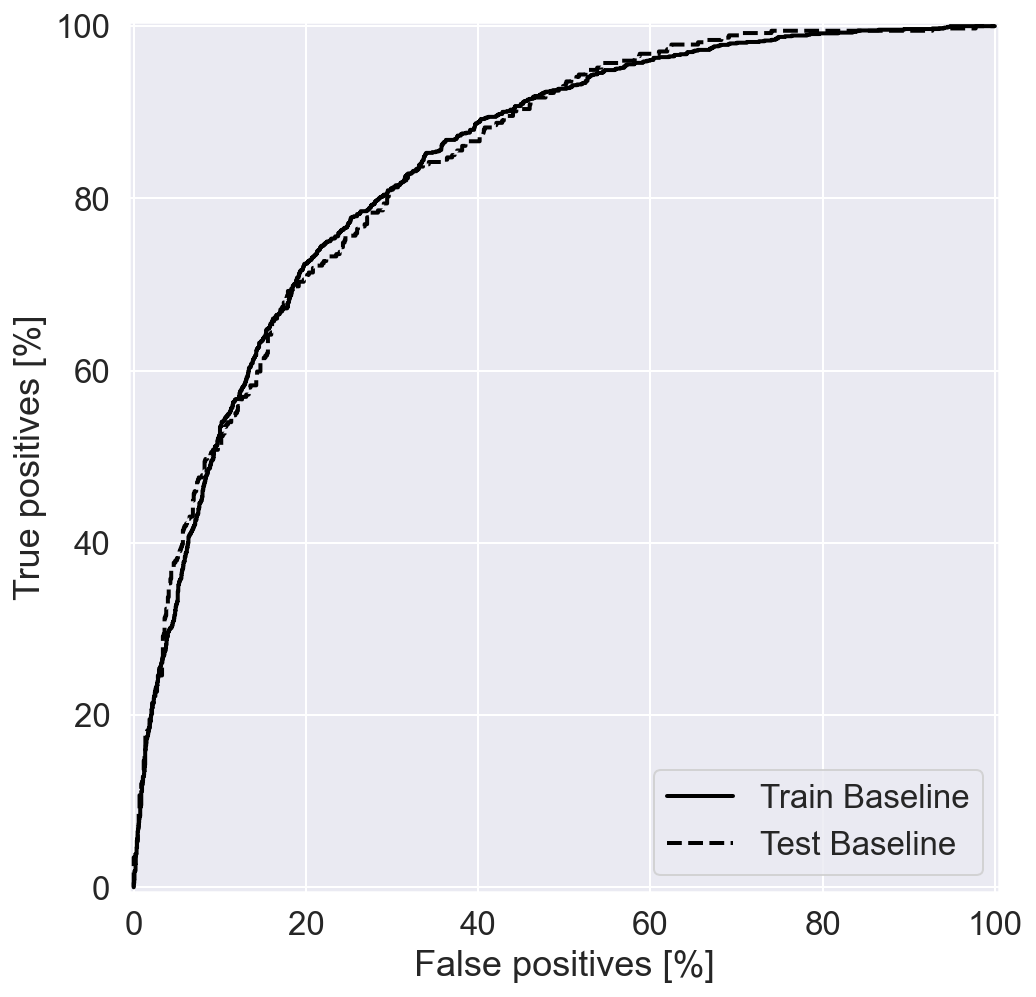

In [35]:
plt.figure(figsize=(8, 8))
PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower right')

In [36]:
def PlotPRC(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(precision, recall, label=name, lw=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

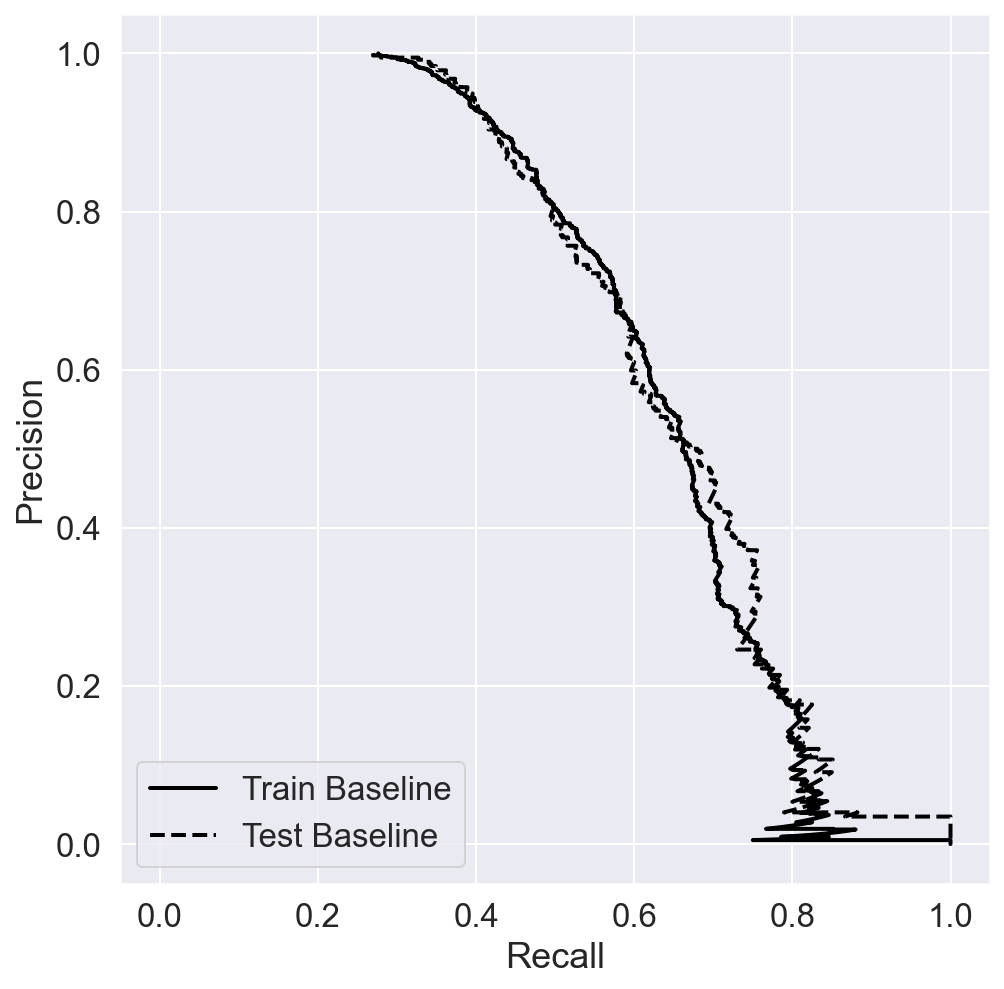

In [37]:
plt.figure(figsize=(8, 8))
PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')
plt.legend(loc='lower left')

In [38]:
weight_for_0 = (1/neg)*(total/2)
weight_for_1 = (1/pos)*(total/2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


In [39]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features,
                                      train_labels,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[early_stopping],
                                      validation_data=(validation_features, validation_labels),
                                      class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
3/3 [==============================] - 2s 324ms/step - loss: 0.8525 - tp: 458.0000 - fp: 1139.0000 - tn: 3198.0000 - fn: 1112.0000 - accuracy: 0.6189 - precision: 0.2868 - recall: 0.2917 - auc: 0.5682 - prc: 0.2828 - val_loss: 0.5997 - val_tp: 13.0000 - val_fp: 45.0000 - val_tn: 781.0000 - val_fn: 286.0000 - val_accuracy: 0.7058 - val_precision: 0.2241 - val_recall: 0.0435 - val_auc: 0.5370 - val_prc: 0.2849
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.8403 - tp: 339.0000 - fp: 1044.0000 - tn: 2260.0000 - fn: 857.0000 - accuracy: 0.5776 - precision: 0.2451 - recall: 0.2834 - auc: 0.4920 - prc: 0.2498 - val_loss: 0.5869 - val_tp: 22.0000 - val_fp: 44.0000 - val_tn: 782.0000 - val_fn: 277.0000 - val_accuracy: 0.7147 - val_precision: 0.3333 - val_recall: 0.0736 - val_auc: 0.5892 - val_prc: 0.3183
Epoch 3/100
3/3 

3/3 [==============================] - 0s 15ms/step - loss: 0.6717 - tp: 616.0000 - fp: 953.0000 - tn: 2351.0000 - fn: 580.0000 - accuracy: 0.6593 - precision: 0.3926 - recall: 0.5151 - auc: 0.6710 - prc: 0.4134 - val_loss: 0.5229 - val_tp: 174.0000 - val_fp: 134.0000 - val_tn: 692.0000 - val_fn: 125.0000 - val_accuracy: 0.7698 - val_precision: 0.5649 - val_recall: 0.5819 - val_auc: 0.7978 - val_prc: 0.5655
Epoch 20/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6647 - tp: 612.0000 - fp: 929.0000 - tn: 2375.0000 - fn: 584.0000 - accuracy: 0.6638 - precision: 0.3971 - recall: 0.5117 - auc: 0.6794 - prc: 0.4291 - val_loss: 0.5215 - val_tp: 176.0000 - val_fp: 134.0000 - val_tn: 692.0000 - val_fn: 123.0000 - val_accuracy: 0.7716 - val_precision: 0.5677 - val_recall: 0.5886 - val_auc: 0.7999 - val_prc: 0.5690
Epoch 21/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6541 - tp: 613.0000 - fp: 841.0000 - tn: 2463.0000 - fn: 583.0000 - accuracy: 0.6836 - pre

3/3 [==============================] - 0s 13ms/step - loss: 0.6056 - tp: 692.0000 - fp: 753.0000 - tn: 2551.0000 - fn: 504.0000 - accuracy: 0.7207 - precision: 0.4789 - recall: 0.5786 - auc: 0.7453 - prc: 0.5016 - val_loss: 0.5078 - val_tp: 195.0000 - val_fp: 144.0000 - val_tn: 682.0000 - val_fn: 104.0000 - val_accuracy: 0.7796 - val_precision: 0.5752 - val_recall: 0.6522 - val_auc: 0.8203 - val_prc: 0.5987
Epoch 39/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6108 - tp: 688.0000 - fp: 766.0000 - tn: 2538.0000 - fn: 508.0000 - accuracy: 0.7169 - precision: 0.4732 - recall: 0.5753 - auc: 0.7468 - prc: 0.4924 - val_loss: 0.5066 - val_tp: 195.0000 - val_fp: 143.0000 - val_tn: 683.0000 - val_fn: 104.0000 - val_accuracy: 0.7804 - val_precision: 0.5769 - val_recall: 0.6522 - val_auc: 0.8213 - val_prc: 0.5994
Epoch 40/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6154 - tp: 647.0000 - fp: 730.0000 - tn: 2574.0000 - fn: 549.0000 - accuracy: 0.7158 - pre

3/3 [==============================] - 0s 14ms/step - loss: 0.5808 - tp: 701.0000 - fp: 684.0000 - tn: 2620.0000 - fn: 495.0000 - accuracy: 0.7380 - precision: 0.5061 - recall: 0.5861 - auc: 0.7786 - prc: 0.5368 - val_loss: 0.4945 - val_tp: 202.0000 - val_fp: 156.0000 - val_tn: 670.0000 - val_fn: 97.0000 - val_accuracy: 0.7751 - val_precision: 0.5642 - val_recall: 0.6756 - val_auc: 0.8322 - val_prc: 0.6143
Epoch 58/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5777 - tp: 737.0000 - fp: 729.0000 - tn: 2575.0000 - fn: 459.0000 - accuracy: 0.7360 - precision: 0.5027 - recall: 0.6162 - auc: 0.7800 - prc: 0.5330 - val_loss: 0.4938 - val_tp: 202.0000 - val_fp: 157.0000 - val_tn: 669.0000 - val_fn: 97.0000 - val_accuracy: 0.7742 - val_precision: 0.5627 - val_recall: 0.6756 - val_auc: 0.8326 - val_prc: 0.6140
Epoch 59/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5804 - tp: 727.0000 - fp: 719.0000 - tn: 2585.0000 - fn: 469.0000 - accuracy: 0.7360 - preci

3/3 [==============================] - 0s 14ms/step - loss: 0.5742 - tp: 766.0000 - fp: 744.0000 - tn: 2560.0000 - fn: 430.0000 - accuracy: 0.7391 - precision: 0.5073 - recall: 0.6405 - auc: 0.7828 - prc: 0.5398 - val_loss: 0.4897 - val_tp: 221.0000 - val_fp: 168.0000 - val_tn: 658.0000 - val_fn: 78.0000 - val_accuracy: 0.7813 - val_precision: 0.5681 - val_recall: 0.7391 - val_auc: 0.8381 - val_prc: 0.6201
Epoch 77/100
3/3 [==============================] - 0s 12ms/step - loss: 0.5610 - tp: 795.0000 - fp: 717.0000 - tn: 2587.0000 - fn: 401.0000 - accuracy: 0.7516 - precision: 0.5258 - recall: 0.6647 - auc: 0.7944 - prc: 0.5628 - val_loss: 0.4896 - val_tp: 221.0000 - val_fp: 168.0000 - val_tn: 658.0000 - val_fn: 78.0000 - val_accuracy: 0.7813 - val_precision: 0.5681 - val_recall: 0.7391 - val_auc: 0.8384 - val_prc: 0.6205
Epoch 78/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5771 - tp: 764.0000 - fp: 743.0000 - tn: 2561.0000 - fn: 432.0000 - accuracy: 0.7389 - preci

3/3 [==============================] - 0s 13ms/step - loss: 0.5499 - tp: 793.0000 - fp: 746.0000 - tn: 2558.0000 - fn: 403.0000 - accuracy: 0.7447 - precision: 0.5153 - recall: 0.6630 - auc: 0.8007 - prc: 0.5653 - val_loss: 0.4838 - val_tp: 222.0000 - val_fp: 169.0000 - val_tn: 657.0000 - val_fn: 77.0000 - val_accuracy: 0.7813 - val_precision: 0.5678 - val_recall: 0.7425 - val_auc: 0.8420 - val_prc: 0.6262
Epoch 96/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5522 - tp: 794.0000 - fp: 720.0000 - tn: 2584.0000 - fn: 402.0000 - accuracy: 0.7507 - precision: 0.5244 - recall: 0.6639 - auc: 0.7987 - prc: 0.5600 - val_loss: 0.4839 - val_tp: 225.0000 - val_fp: 170.0000 - val_tn: 656.0000 - val_fn: 74.0000 - val_accuracy: 0.7831 - val_precision: 0.5696 - val_recall: 0.7525 - val_auc: 0.8421 - val_prc: 0.6260
Epoch 97/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5556 - tp: 783.0000 - fp: 753.0000 - tn: 2551.0000 - fn: 413.0000 - accuracy: 0.7409 - preci

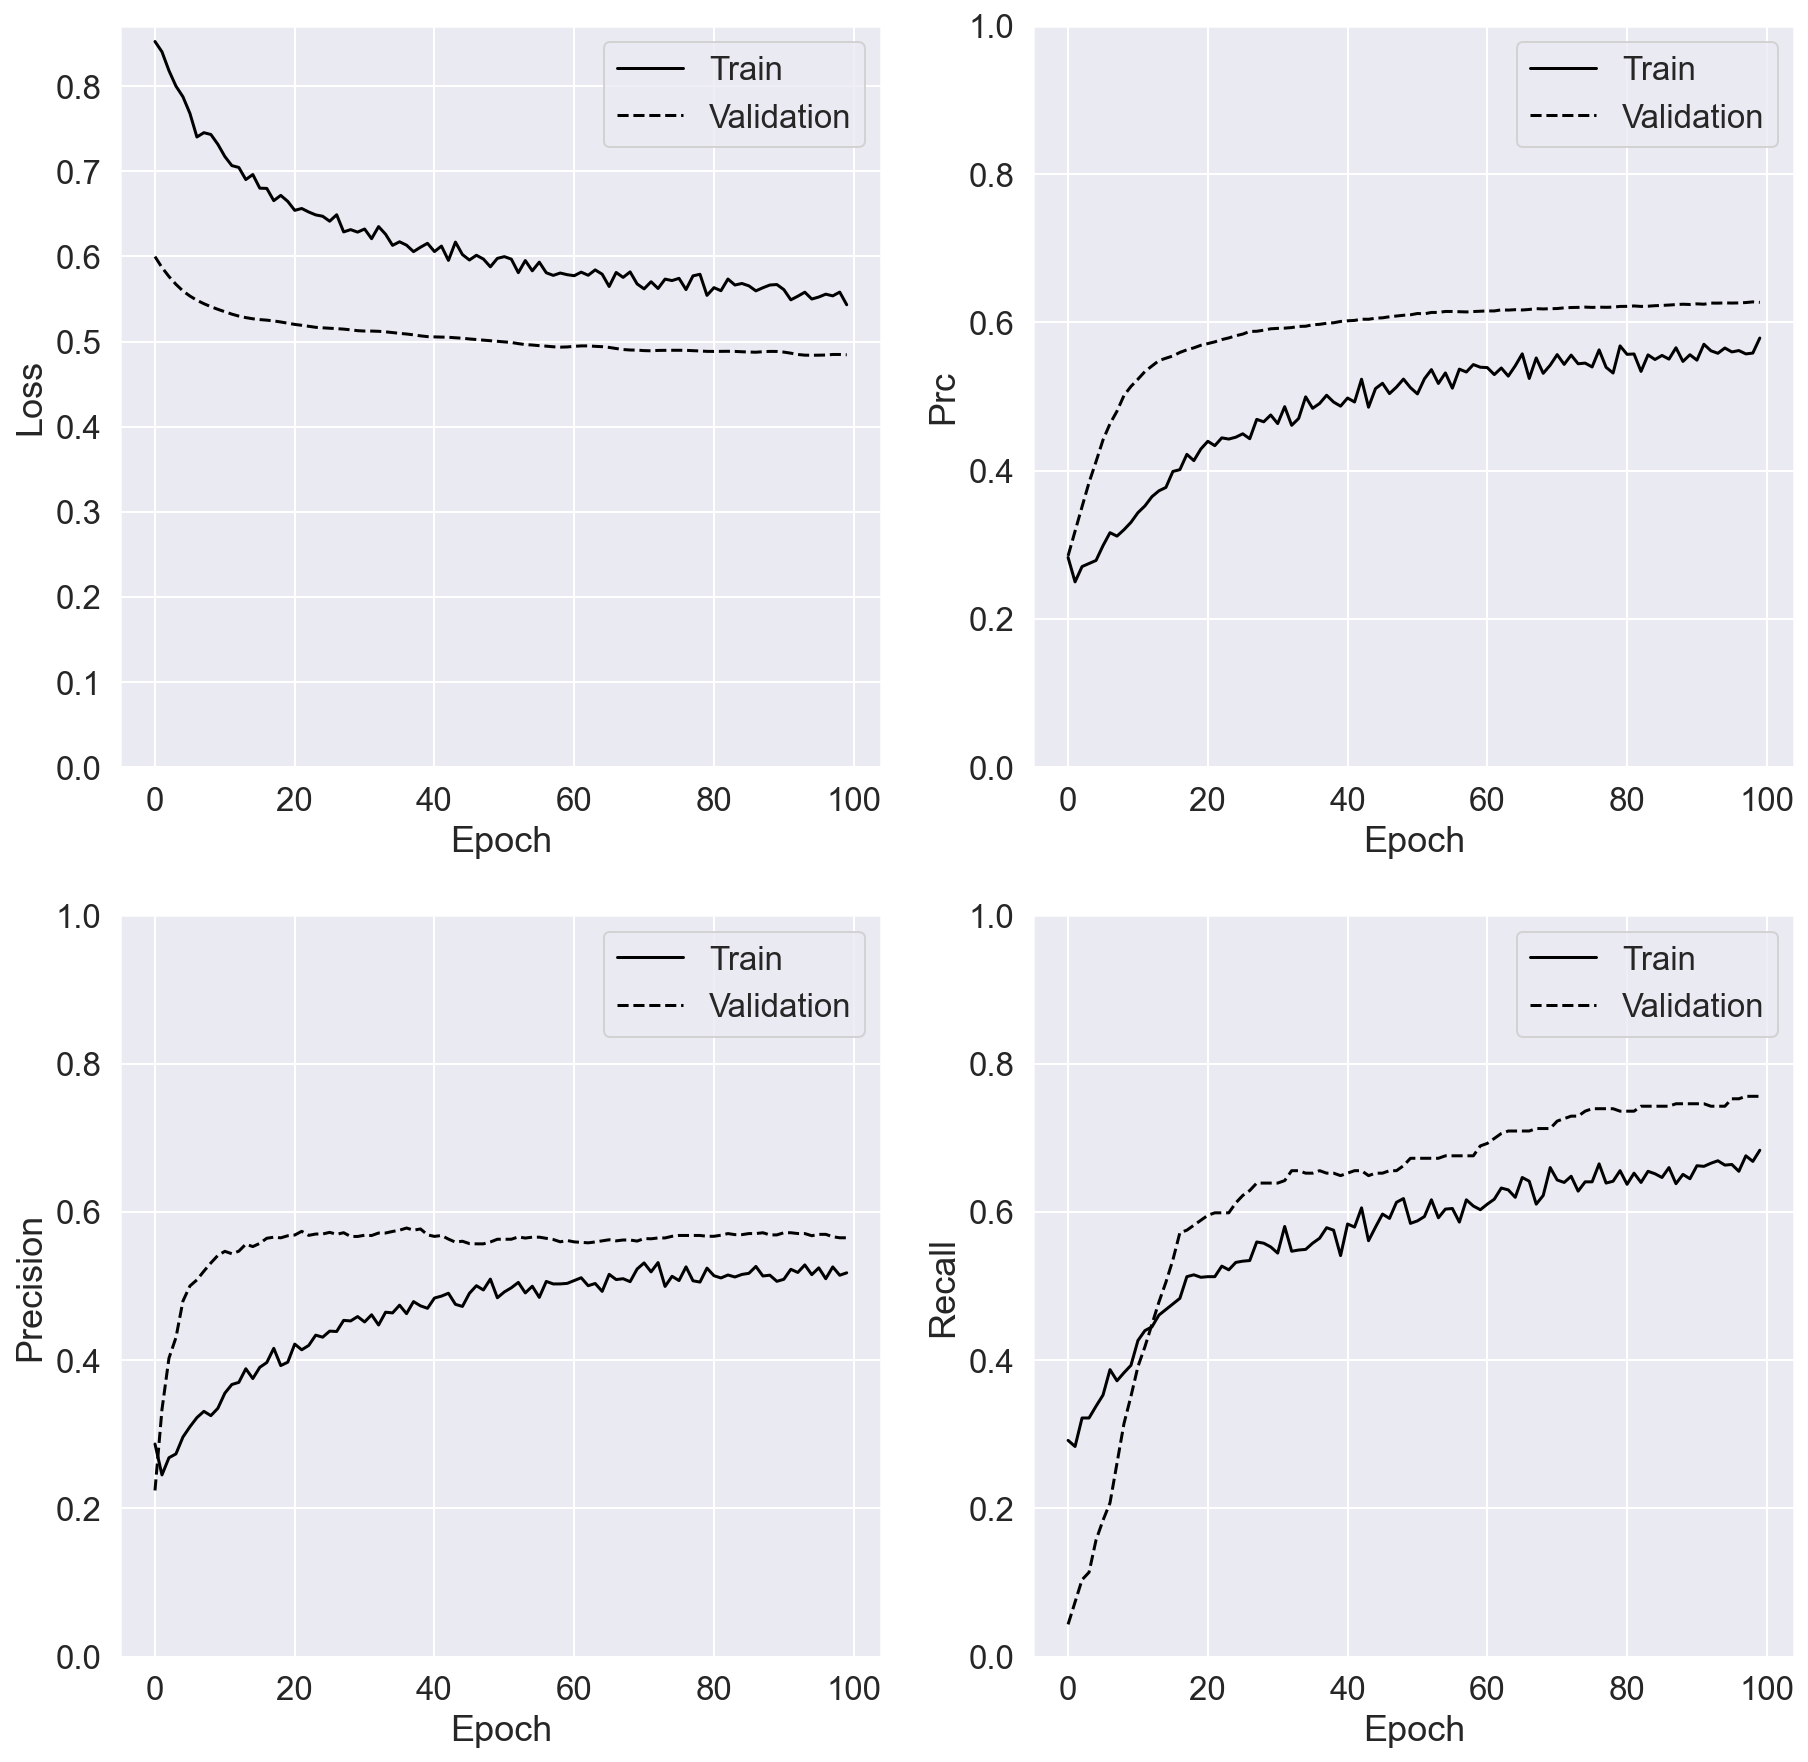

In [40]:
PlotMetrics(weighted_history)

In [41]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.4810374081134796
tp :  268.0
fp :  204.0
tn :  829.0
fn :  106.0
accuracy :  0.7796730399131775
precision :  0.5677965879440308
recall :  0.7165775299072266
auc :  0.8363988399505615
prc :  0.6460776925086975


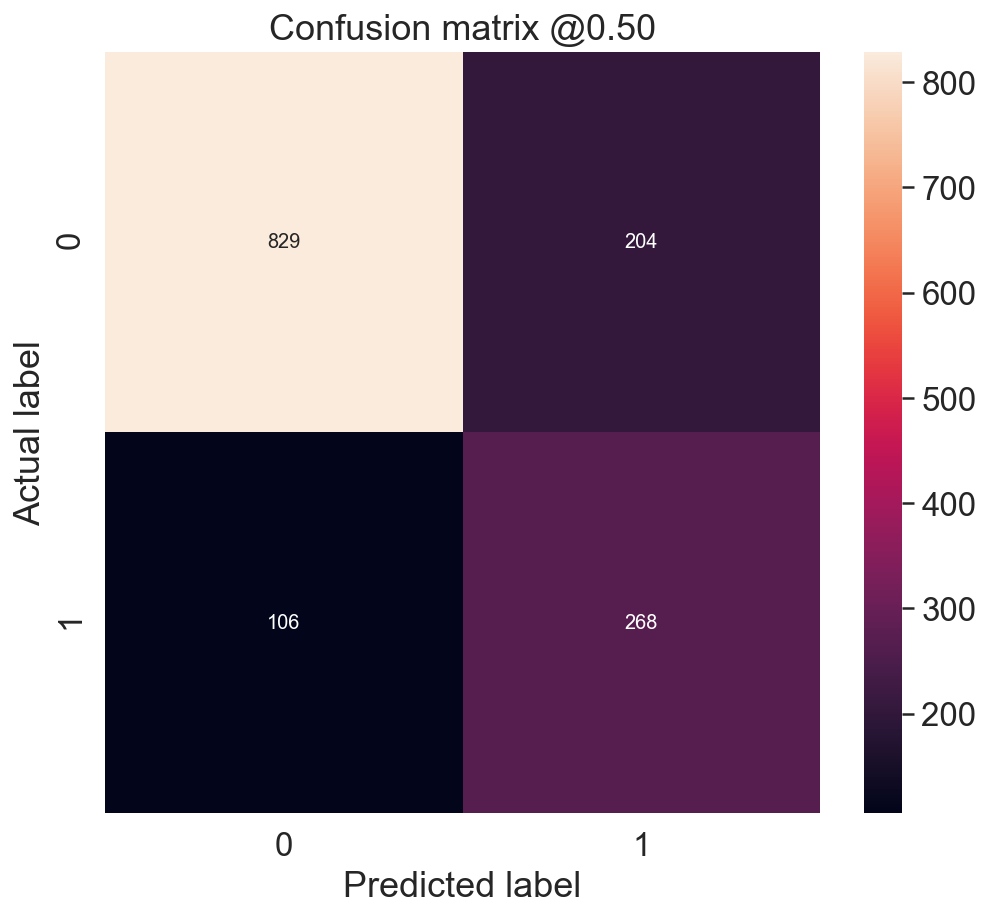

In [42]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

ConfMatrix(test_labels, test_predictions_weighted)

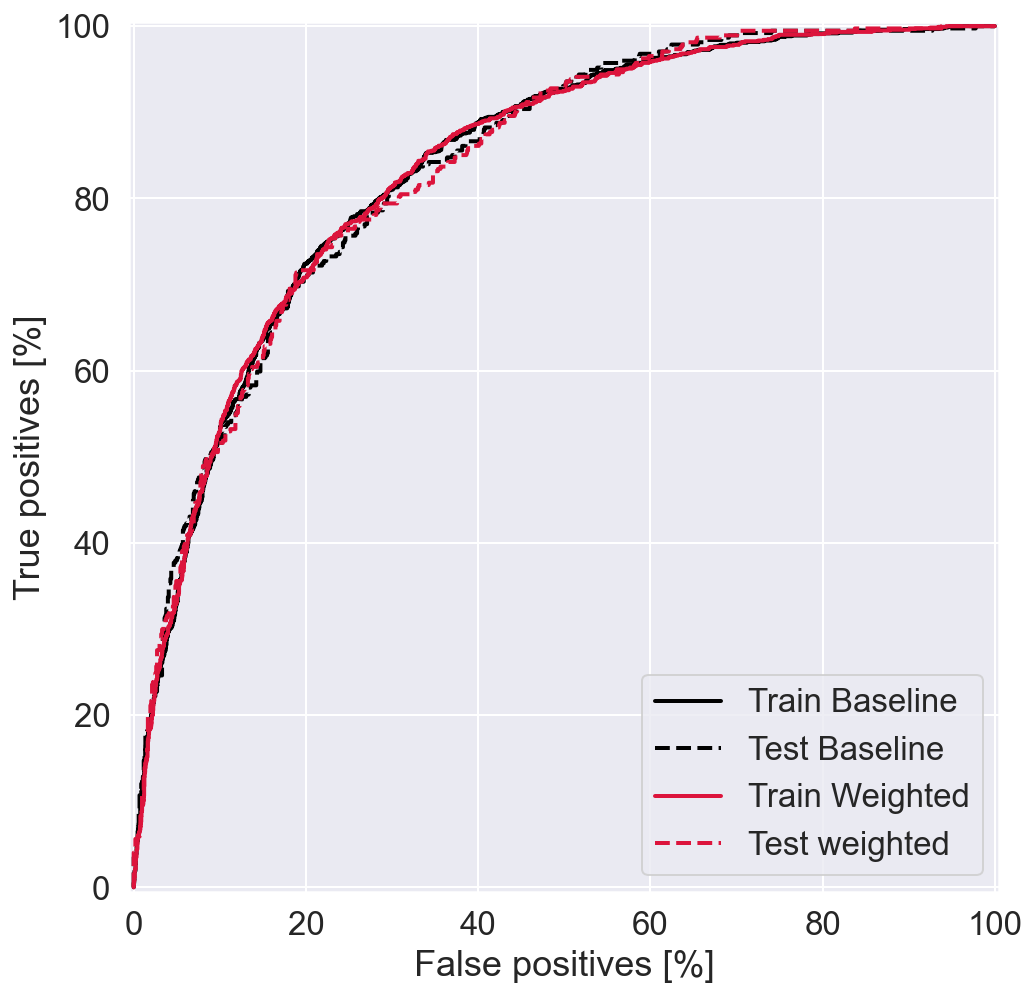

In [43]:
plt.figure(figsize=(8, 8))

PlotROC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotROC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotROC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotROC('Test weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower right')

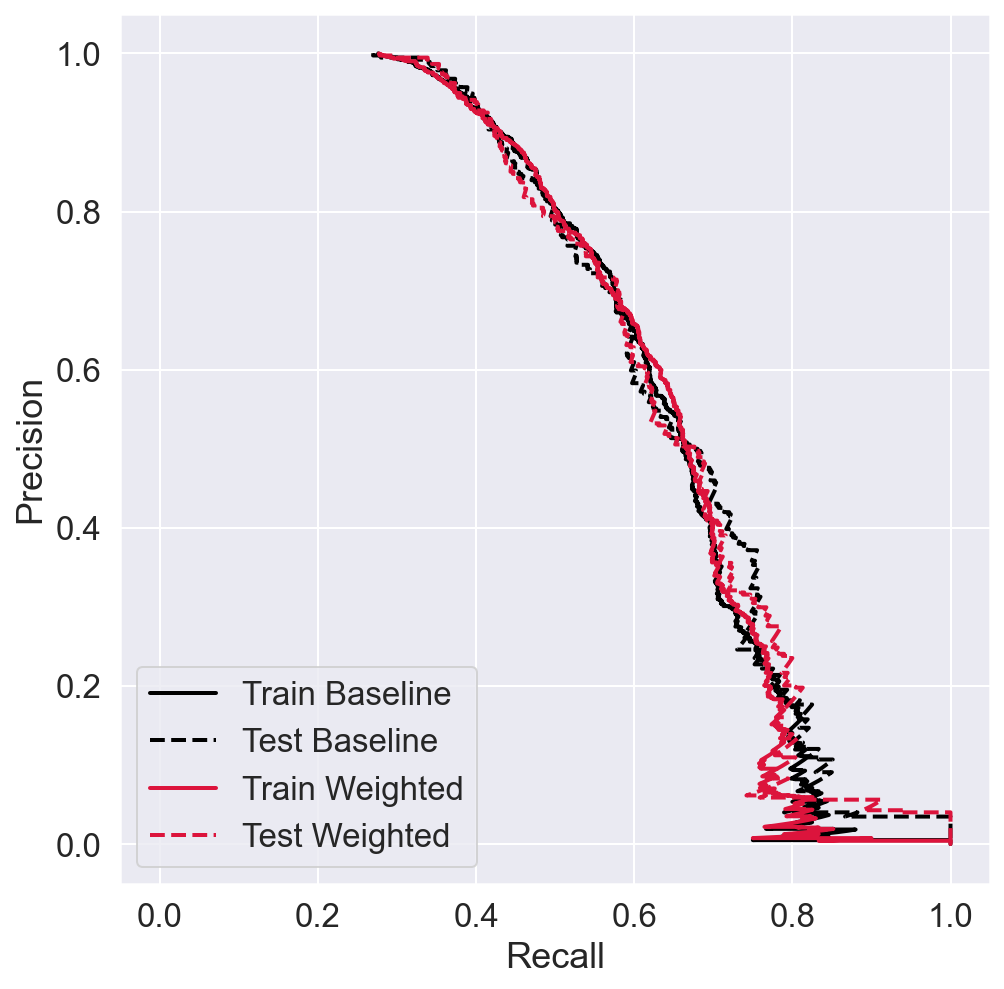

In [44]:
plt.figure(figsize=(8, 8))

PlotPRC('Train Baseline', train_labels, train_predictions_baseline, color='black')
PlotPRC('Test Baseline', test_labels, test_predictions_baseline, color='black', ls='--')

PlotPRC('Train Weighted', train_labels, train_predictions_weighted, color='crimson')
PlotPRC('Test Weighted', test_labels, test_predictions_weighted, color='crimson', ls='--')

plt.legend(loc='lower left')